<a href="https://colab.research.google.com/github/YannMaa/traco_2024/blob/colab-dev/solution_yannis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Drive Stuff

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install ultralytics
!pip install deep-sort-realtime
!pip install opencv-python
# !pip install gdrive
!pip install cv2
!pip install deep-sort-realtime


  Using cached ultralytics-8.3.137-py3-none-any.whl.metadata (37 kB)
  Using cached ultralytics_thop-2.0.14-py3-none-any.whl.metadata (9.4 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.

# Preprocessing

In [ ]:
import os
import cv2
import pandas as pd
import shutil
from collections import defaultdict

# Funktion zum Extrahieren von Frames mit Prüfung auf fehlerhafte Speicherung
def extract_frames(video_path, image_folder, video_id):
    cap = cv2.VideoCapture(video_path)
    frame_id = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        image_path = os.path.join(image_folder, f"{video_id}_frame_{frame_id}.jpg")
        success = cv2.imwrite(image_path, frame)
        if not success:
            print(f"[Fehler] Bild konnte nicht gespeichert werden: {image_path}")
        frame_id += 1
    cap.release()

# Funktion zur Berechnung der normalisierten YOLO Bounding Box (feste Größe: 5% des Bildes)
def convert_to_yolo_format(x, y, image_width, image_height):
    # Definiere die feste Größe der Bounding Box (z. B. 5% des Bildes)
    box_w = image_width * 0.05
    box_h = image_height * 0.05

    # Berechne den Mittelpunkt der Box
    x_center = x / image_width
    y_center = y / image_height

    # Korrigiere die Position des Mittelpunkts, falls er zu nah am Rand ist
    if x_center - box_w / (2 * image_width) < 0:
        x_center = box_w / (2 * image_width)  # Verschiebe die Box nach links
    elif x_center + box_w / (2 * image_width) > 1:
        x_center = 1 - box_w / (2 * image_width)  # Verschiebe die Box nach rechts

    if y_center - box_h / (2 * image_height) < 0:
        y_center = box_h / (2 * image_height)  # Verschiebe die Box nach oben
    elif y_center + box_h / (2 * image_height) > 1:
        y_center = 1 - box_h / (2 * image_height)  # Verschiebe die Box nach unten

    # Berechne die neuen Bildkoordinaten basierend auf dem verschobenen Mittelpunkt
    x1 = (x_center - box_w / (2 * image_width)) * image_width
    y1 = (y_center - box_h / (2 * image_height)) * image_height
    x2 = (x_center + box_w / (2 * image_width)) * image_width
    y2 = (y_center + box_h / (2 * image_height)) * image_height

    # Berechne die Breite und Höhe der Bounding Box
    width_norm = (x2 - x1) / image_width
    height_norm = (y2 - y1) / image_height

    # Validierung, um sicherzustellen, dass die Box immer innerhalb des Bildes bleibt
    if not (0 <= x_center <= 1 and 0 <= y_center <= 1 and
            0 < width_norm <= 1 and 0 < height_norm <= 1):
        print(f"⚠️ Ungültige Bounding Box übersprungen:")
        print(f"x_center: {x_center}, y_center: {y_center}, width_norm: {width_norm}, height_norm: {height_norm}")
        return None

    return x_center, y_center, width_norm, height_norm




# CSV-Datei verarbeiten
def process_csv_file(csv_file, image_folder, label_folder, video_id):
    df = pd.read_csv(csv_file)
    label_dict = defaultdict(list)

    for _, row in df.iterrows():
        frame_id = int(row['t'])
        x, y = row['x'], row['y']
        image_path = os.path.join(image_folder, f"{video_id}_frame_{frame_id}.jpg")

        if not os.path.exists(image_path) or os.path.getsize(image_path) == 0:
            print(f"[Warnung] Fehlendes oder beschädigtes Bild: {image_path}")
            continue

        image = cv2.imread(image_path)
        if image is None:
            print(f"[Warnung] Bild konnte nicht gelesen werden: {image_path}")
            continue

        h, w, _ = image.shape
        result = convert_to_yolo_format(x, y, w, h)
        if result is None:
            continue

        x_c, y_c, w_n, h_n = result
        label_line = f"0 {x_c:.4f} {y_c:.4f} {w_n:.4f} {h_n:.4f}"
        label_dict[frame_id].append(label_line)

    for frame_id, lines in label_dict.items():
        label_file = os.path.join(label_folder, f"{video_id}_frame_{frame_id}.txt")
        unique_lines = sorted(set(lines))  # Duplikate entfernen
        with open(label_file, 'w') as f:
            for line in unique_lines:
                f.write(line + "\n")

# Hauptfunktion zum Verarbeiten aller Daten im Trainingsordner
def process_all_training_data(folder_path):
    image_folder = os.path.join(folder_path, 'images')
    label_folder = os.path.join(folder_path, 'labels')

    # Alte Inhalte löschen und Ordner neu erstellen
    for folder in [image_folder, label_folder]:
        if os.path.exists(folder):
            shutil.rmtree(folder)
        os.makedirs(folder)

    for filename in os.listdir(folder_path):
        if filename.endswith('.mp4'):
            video_path = os.path.join(folder_path, filename)
            video_id = os.path.splitext(filename)[0]

            csv_file = os.path.join(folder_path, f"{video_id}.csv")
            if not os.path.exists(csv_file):
                print(f"[Übersprungen] Keine CSV-Datei für {video_id} gefunden.")
                continue

            print(f"[Verarbeitung] Starte mit {video_id}...")
            extract_frames(video_path, image_folder, video_id)
            process_csv_file(csv_file, image_folder, label_folder, video_id)

# START
process_all_training_data('training')
print("✅ Fertig")


[Verarbeitung] Starte mit training085...
[Verarbeitung] Starte mit training069...
[Verarbeitung] Starte mit training020...
[Verarbeitung] Starte mit training059...
[Verarbeitung] Starte mit training080...
[Verarbeitung] Starte mit training049...
[Verarbeitung] Starte mit training070...
[Verarbeitung] Starte mit training029...
[Verarbeitung] Starte mit training0100...
[Verarbeitung] Starte mit training077...
[Verarbeitung] Starte mit training022...
[Verarbeitung] Starte mit training03...
[Verarbeitung] Starte mit training042...
[Verarbeitung] Starte mit training088...
[Verarbeitung] Starte mit training081...
[Verarbeitung] Starte mit training023...
[Verarbeitung] Starte mit training072...
[Verarbeitung] Starte mit training040...
[Verarbeitung] Starte mit training035...
[Verarbeitung] Starte mit training037...
[Verarbeitung] Starte mit training051...
[Verarbeitung] Starte mit training013...
[Verarbeitung] Starte mit training050...
[Verarbeitung] Starte mit training09...
[Verarbeitung] St

In [ ]:

# import os
# import cv2
# import pandas as pd
# import json
# import shutil

# # Funktion zum Extrahieren von Frames mit eindeutigen Namen
# def extract_frames(video_path, image_folder, video_id):
#     cap = cv2.VideoCapture(video_path)
#     frame_id = 0
#     while True:
#         ret, frame = cap.read()
#         if not ret:
#             break
#         # Eindeutiger Bildname pro Video und Frame
#         image_path = os.path.join(image_folder, f"{video_id}_frame_{frame_id}.jpg")
#         cv2.imwrite(image_path, frame)
#         frame_id += 1
#     cap.release()
#     print(f"Frames aus {video_path} gespeichert unter {image_folder}")

# # Funktion zur Berechnung der normalisierten Bounding Box
# def convert_to_yolo_format(x, y, image_width, image_height):
#     width = 50
#     height = 50
#     x_center = x / image_width
#     y_center = y / image_height
#     width_norm = width / image_width
#     height_norm = height / image_height
#     return x_center, y_center, width_norm, height_norm

# # Verarbeitung einer CSV- und .traco-Datei für ein Video
# def process_files(csv_file, traco_file, image_folder, label_folder, video_id):
#     df = pd.read_csv(csv_file)
#     with open(traco_file, 'r') as f:
#         traco_data = json.load(f)

#     for i, row in df.iterrows():
#         frame_id = int(row['t'])
#         x, y = row['x'], row['y']
#         image_path = os.path.join(image_folder, f"{video_id}_frame_{frame_id}.jpg")
#         image = cv2.imread(image_path)
#         if image is None:
#             continue
#         image_height, image_width, _ = image.shape
#         x_center, y_center, width_norm, height_norm = convert_to_yolo_format(x, y, image_width, image_height)
#         label_file = os.path.join(label_folder, f"{video_id}_frame_{frame_id}.txt")
#         with open(label_file, 'a') as f:
#             f.write(f"0 {x_center} {y_center} {width_norm} {height_norm}\n")

#     for roi in traco_data['rois']:
#         frame_id = roi['z']
#         x, y = roi['pos']
#         image_path = os.path.join(image_folder, f"{video_id}_frame_{frame_id}.jpg")
#         image = cv2.imread(image_path)
#         if image is None:
#             continue
#         image_height, image_width, _ = image.shape
#         x_center, y_center, width_norm, height_norm = convert_to_yolo_format(x, y, image_width, image_height)
#         label_file = os.path.join(label_folder, f"{video_id}_frame_{frame_id}.txt")
#         with open(label_file, 'a') as f:
#             f.write(f"0 {x_center} {y_center} {width_norm} {height_norm}\n")

# # Hauptfunktion zur Verarbeitung ALLER Videos im Verzeichnis
# def process_all_training_data(folder_path):
#     image_folder = os.path.join(folder_path, 'images')
#     label_folder = os.path.join(folder_path, 'labels')

#     # Alte Inhalte löschen (optional, aber empfohlen)
#     for folder in [image_folder, label_folder]:
#         if os.path.exists(folder):
#             shutil.rmtree(folder)
#         os.makedirs(folder)

#     # Alle Videodateien im Ordner durchgehen
#     for filename in os.listdir(folder_path):
#         if filename.endswith('.mp4'):
#             video_path = os.path.join(folder_path, filename)
#             video_id = os.path.splitext(filename)[0]  # z. B. "training01"

#             csv_file = os.path.join(folder_path, f"{video_id}.csv")
#             traco_file = os.path.join(folder_path, f"{video_id}.traco")
#             if not os.path.exists(csv_file) or not os.path.exists(traco_file):
#                 print(f"Fehlende Dateien für {video_id}, überspringe...")
#                 continue

#             print(f"Verarbeite {video_id}...")
#             extract_frames(video_path, image_folder, video_id)
#             process_files(csv_file, traco_file, image_folder, label_folder, video_id)

# # STARTE den Prozess
# # process_all_training_data('/content/drive/MyDrive/traco_2024/training')
# process_all_training_data('training')


Verarbeite training085...
Frames aus training/training085.mp4 gespeichert unter training/images
Verarbeite training069...
Frames aus training/training069.mp4 gespeichert unter training/images
Verarbeite training020...
Frames aus training/training020.mp4 gespeichert unter training/images
Verarbeite training059...
Frames aus training/training059.mp4 gespeichert unter training/images
Verarbeite training080...
Frames aus training/training080.mp4 gespeichert unter training/images
Verarbeite training049...
Frames aus training/training049.mp4 gespeichert unter training/images
Verarbeite training070...
Frames aus training/training070.mp4 gespeichert unter training/images
Verarbeite training029...
Frames aus training/training029.mp4 gespeichert unter training/images
Verarbeite training0100...
Frames aus training/training0100.mp4 gespeichert unter training/images
Verarbeite training077...
Frames aus training/training077.mp4 gespeichert unter training/images
Verarbeite training022...
Frames aus t

# Train & Validation Split

In [ ]:
import os
import random
import shutil

# Eingabe- und Ausgabeordner
images_dir = "training/images"
labels_dir = "training/labels"
video_dir = "training"

train_images_out = "training/model_training/images"
train_labels_out = "training/model_training/labels"
val_images_out = "training/model_validation/images"
val_labels_out = "training/model_validation/labels"

# Zielordner neu erstellen
for d in [train_images_out, train_labels_out, val_images_out, val_labels_out]:
    if os.path.exists(d):
        shutil.rmtree(d)
    os.makedirs(d, exist_ok=True)

# Videos identifizieren
video_files = [f for f in os.listdir(video_dir) if f.endswith(".mp4")]
video_ids = list(set(os.path.splitext(f)[0] + "_" for f in video_files))

# Shuffle und Auswahl von 20
random.shuffle(video_ids)
selected_video_ids = video_ids[:20]
print(f"Ausgewählte Video-IDs: {selected_video_ids}")

# Helfer: Label-Datei validieren
def is_valid_label_file(path):
    if not os.path.exists(path):
        return False
    with open(path, "r") as f:
        lines = f.readlines()
    if len(lines) == 0:
        return False
    for line in lines:
        parts = line.strip().split()
        if len(parts) != 5:
            return False
        try:
            [float(x) for x in parts[1:]]
        except:
            return False
    return True

# Sammlungen
val_image_files = []
val_label_files = []

# Sammle gültige val-Daten
for vid in selected_video_ids:
    matched_imgs = [f for f in os.listdir(images_dir) if f.startswith(vid) and f.endswith((".jpg", ".png"))]
    matched_labels = [f.replace(".jpg", ".txt").replace(".png", ".txt") for f in matched_imgs]

    valid_imgs = []
    valid_labels = []

    for img, label in zip(matched_imgs, matched_labels):
        img_path = os.path.join(images_dir, img)
        label_path = os.path.join(labels_dir, label)

        if os.path.exists(img_path) and is_valid_label_file(label_path):
            valid_imgs.append(img)
            valid_labels.append(label)
        else:
            print(f"⚠️ Ungültiges Paar übersprungen: {img}, {label}")

    if len(valid_imgs) < 100:
        print(f"⚠️ Nicht genug gültige Bilder für {vid}, übersprungen ({len(valid_imgs)} gültig).")
        continue

    val_image_files.extend(valid_imgs[:100])
    val_label_files.extend(valid_labels[:100])

# Bestimme Trainingsdaten (alles, was nicht in val ist)
all_images = set([f for f in os.listdir(images_dir) if f.endswith((".jpg", ".png"))])
all_labels = set([f for f in os.listdir(labels_dir) if f.endswith(".txt")])

val_images_set = set(val_image_files)
val_labels_set = set(val_label_files)

train_image_files = []
train_label_files = []

for img in sorted(all_images - val_images_set):
    label = img.replace(".jpg", ".txt").replace(".png", ".txt")
    if label in all_labels and is_valid_label_file(os.path.join(labels_dir, label)):
        train_image_files.append(img)
        train_label_files.append(label)

# Kopierfunktion
def copy_files(file_list, src_dir, dst_dir):
    for f in file_list:
        src = os.path.join(src_dir, f)
        dst = os.path.join(dst_dir, f)
        shutil.copy(src, dst)

# Dateien kopieren
copy_files(train_image_files, images_dir, train_images_out)
copy_files(train_label_files, labels_dir, train_labels_out)
copy_files(val_image_files, images_dir, val_images_out)
copy_files(val_label_files, labels_dir, val_labels_out)

print(f"\n✅ Trainingsset: {len(train_image_files)} Bilder, {len(train_label_files)} Labels")
print(f"✅ Validierungsset: {len(val_image_files)} Bilder, {len(val_label_files)} Labels")


Ausgewählte Video-IDs: ['training091_', 'training020_', 'training097_', 'training048_', 'training077_', 'training041_', 'training062_', 'training057_', 'training06_', 'training082_', 'training061_', 'training05_', 'training059_', 'training013_', 'training093_', 'training087_', 'training079_', 'training085_', 'training098_', 'training076_']

✅ Trainingsset: 8087 Bilder, 8087 Labels
✅ Validierungsset: 2000 Bilder, 2000 Labels


In [ ]:

# import os
# import random
# import shutil

# # Pfade definieren
# images_dir = "training/images"
# labels_dir = "training/labels"
# video_dir = "training"

# train_images_out = "training/model_training/images"
# train_labels_out = "training/model_training/labels"
# val_images_out = "training/model_validation/images"
# val_labels_out = "training/model_validation/labels"

# # Zielordner erstellen, wenn sie noch nicht existieren
# for d in [train_images_out, train_labels_out, val_images_out, val_labels_out]:
#     os.makedirs(d, exist_ok=True)

# # Alle Video-Dateien auflisten (angenommen: es gibt Bild- und Label-Dateien mit den gleichen Namen wie die Videos)
# video_files = [f for f in os.listdir(video_dir) if f.endswith(".mp4")]  # Liste der Video-Dateien

# # Video-IDs extrahieren und sicherstellen, dass wir den Unterstrich anhängen
# video_ids = list(set(os.path.splitext(f)[0] for f in video_files))  # Video-IDs extrahieren

# # Füge '_' an jede ID an
# video_ids = [vid_id + '_' for vid_id in video_ids]  # Unterstrich zu jeder ID hinzufügen


# # Zufällig 20 Video-IDs auswählen
# random.shuffle(video_ids)
# selected_video_ids = video_ids[:20]

# print(f"Ausgewählte Video-IDs: {selected_video_ids}")

# # Für jedes ausgewählte Video die entsprechenden Bilder und Labels kopieren
# train_image_files = []
# train_label_files = []
# val_image_files = []
# val_label_files = []

# # Gehe durch jede ausgewählte Video-ID
# for video_id in selected_video_ids:
#     # Bild- und Label-Dateien für das Video finden
#     img_files = [f for f in os.listdir(images_dir) if f.startswith(video_id) and (f.endswith(".jpg") or f.endswith(".png"))]
#     label_files = [f for f in os.listdir(labels_dir) if f.startswith(video_id) and f.endswith(".txt")]

#     # Sicherstellen, dass wir genau 100 Bilder und 100 Labels haben
#     if len(img_files) != 101 or len(label_files) != 101:
#         print(f"Warnung: Für Video-ID {video_id} fehlen Bilder oder Labels!")
#         print(len(img_files))
#         print((len(label_files)))
#         continue

#     # Die Bild- und Label-Dateien nach der Reihenfolge sortieren
#     img_files.sort()
#     label_files.sort()

#     print(video_id)
#     # print(img_files)
#     # print(len(img_files[:101]))

#     # Slicing der ersten X Dateien für die Validierung (z. B. 20 Bilder/Labels für die Validierung)
#     val_image_files.extend(img_files)
#     val_label_files.extend(label_files)



# # Der Rest geht ins Training
# # Train-Dateien durch Subtraktion bestimmen
# all_image_files = set(os.listdir(images_dir))
# all_label_files = set(os.listdir(labels_dir))

# val_image_files_set = set(val_image_files)
# val_label_files_set = set(val_label_files)

# train_image_files = list(all_image_files - val_image_files_set)
# train_label_files = list(all_label_files - val_label_files_set)


# # Funktion zum Kopieren der Dateien in die Zielordner
# def copy_files(file_list, src_dir, dst_dir):
#     for file in file_list:
#         src_path = os.path.join(src_dir, file)
#         dst_path = os.path.join(dst_dir, file)

#         # Sicherstellen, dass die Datei existiert
#         if not os.path.exists(src_path):
#             print(f"Fehler: Datei nicht gefunden - {src_path}")
#             continue

#         shutil.copy(src_path, dst_path)

# # Kopiere die Bild- und Label-Dateien in den jeweiligen Ordner
# copy_files(train_image_files, images_dir, train_images_out)
# copy_files(train_label_files, labels_dir, train_labels_out)
# copy_files(val_image_files, images_dir, val_images_out)
# copy_files(val_label_files, labels_dir, val_labels_out)

# print(f"Trainingsset: {len(train_image_files)} Bilder, {len(train_label_files)} Labels")
# print(f"Validierungsset: {len(val_image_files)} Bilder, {len(val_label_files)} Labels")






Ausgewählte Video-IDs: ['training033_', 'training082_', 'training038_', 'training020_', 'training031_', 'training030_', 'training099_', 'training054_', 'training03_', 'training016_', 'training055_', 'training072_', 'training032_', 'training094_', 'training041_', 'training076_', 'training087_', 'training081_', 'training079_', 'training015_']
training033_
training082_
training038_
training020_
training031_
training030_
training099_
training054_
training03_
training016_
training055_
training072_
training032_
training094_
training041_
training076_
training087_
training081_
training079_
training015_
Trainingsset: 8071 Bilder, 8067 Labels
Validierungsset: 2020 Bilder, 2020 Labels


# YAML File Creation

In [ ]:
import yaml
import os

# Definiere die Pfade
base_path = '/home/hpc/tovl/tovl100v/traco_2024/training'
train_images_path = 'model_training/images'
val_images_path = 'model_validation/images'

# Definiere die Anzahl der Klassen und die Klassennamen
num_classes = 1
class_names = ['hexbug']

# Erstelle das Dictionary für die YAML-Struktur
dataset = {
    'path': base_path,
    'train': train_images_path,
    'val': val_images_path,
    'nc': num_classes,
    'names': class_names
}

# Speichere die YAML-Datei
yaml_file_path = os.path.join(base_path, 'dataset.yaml')

# Schreibe das Dictionary in die YAML-Datei
with open(yaml_file_path, 'w') as file:
    yaml.dump(dataset, file, default_flow_style=False)

print(f'Dataset YAML-Datei wurde erfolgreich erstellt: {yaml_file_path}')



TypeError: unsupported operand type(s) for /: 'str' and 'str'

# Model Training - Yolov8n

In [ ]:
from ultralytics import YOLO
import os
import torch

!rm /home/hpc/tovl/tovl100v/traco_2024/training/model_training/labels.cache  # remove cache
!rm /home/hpc/tovl/tovl100v/traco_2024/training/model_validation/labels.cache  # remove cache

# load YOLOv8 Modell
model = YOLO("yolov8n.pt")

# traiing
# yaml filepath
dataset_yaml = "/home/hpc/tovl/tovl100v/traco_2024/training/dataset.yaml"

# train model
print(f"CUDA verfügbar: {torch.cuda.is_available()}")
print(f"GPU Name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'Kein GPU vorhanden'}")

# train model
#btahc size
results = model.train(data=dataset_yaml, epochs=30, device=0, batch = 32, amp=False, workers=4, patience=5)  # device=0 => GPU
best_model_path = model.ckpt_path  # Pfad zum besten Modell
print("Bestes Modell gespeichert unter:", best_model_path)

# copy to a dir
import shutil
shutil.copy(best_model_path, "yolov8_model_y.pt")



TypeError: YOLO.__init__() got an unexpected keyword argument 'transfer'

# Plot Training History

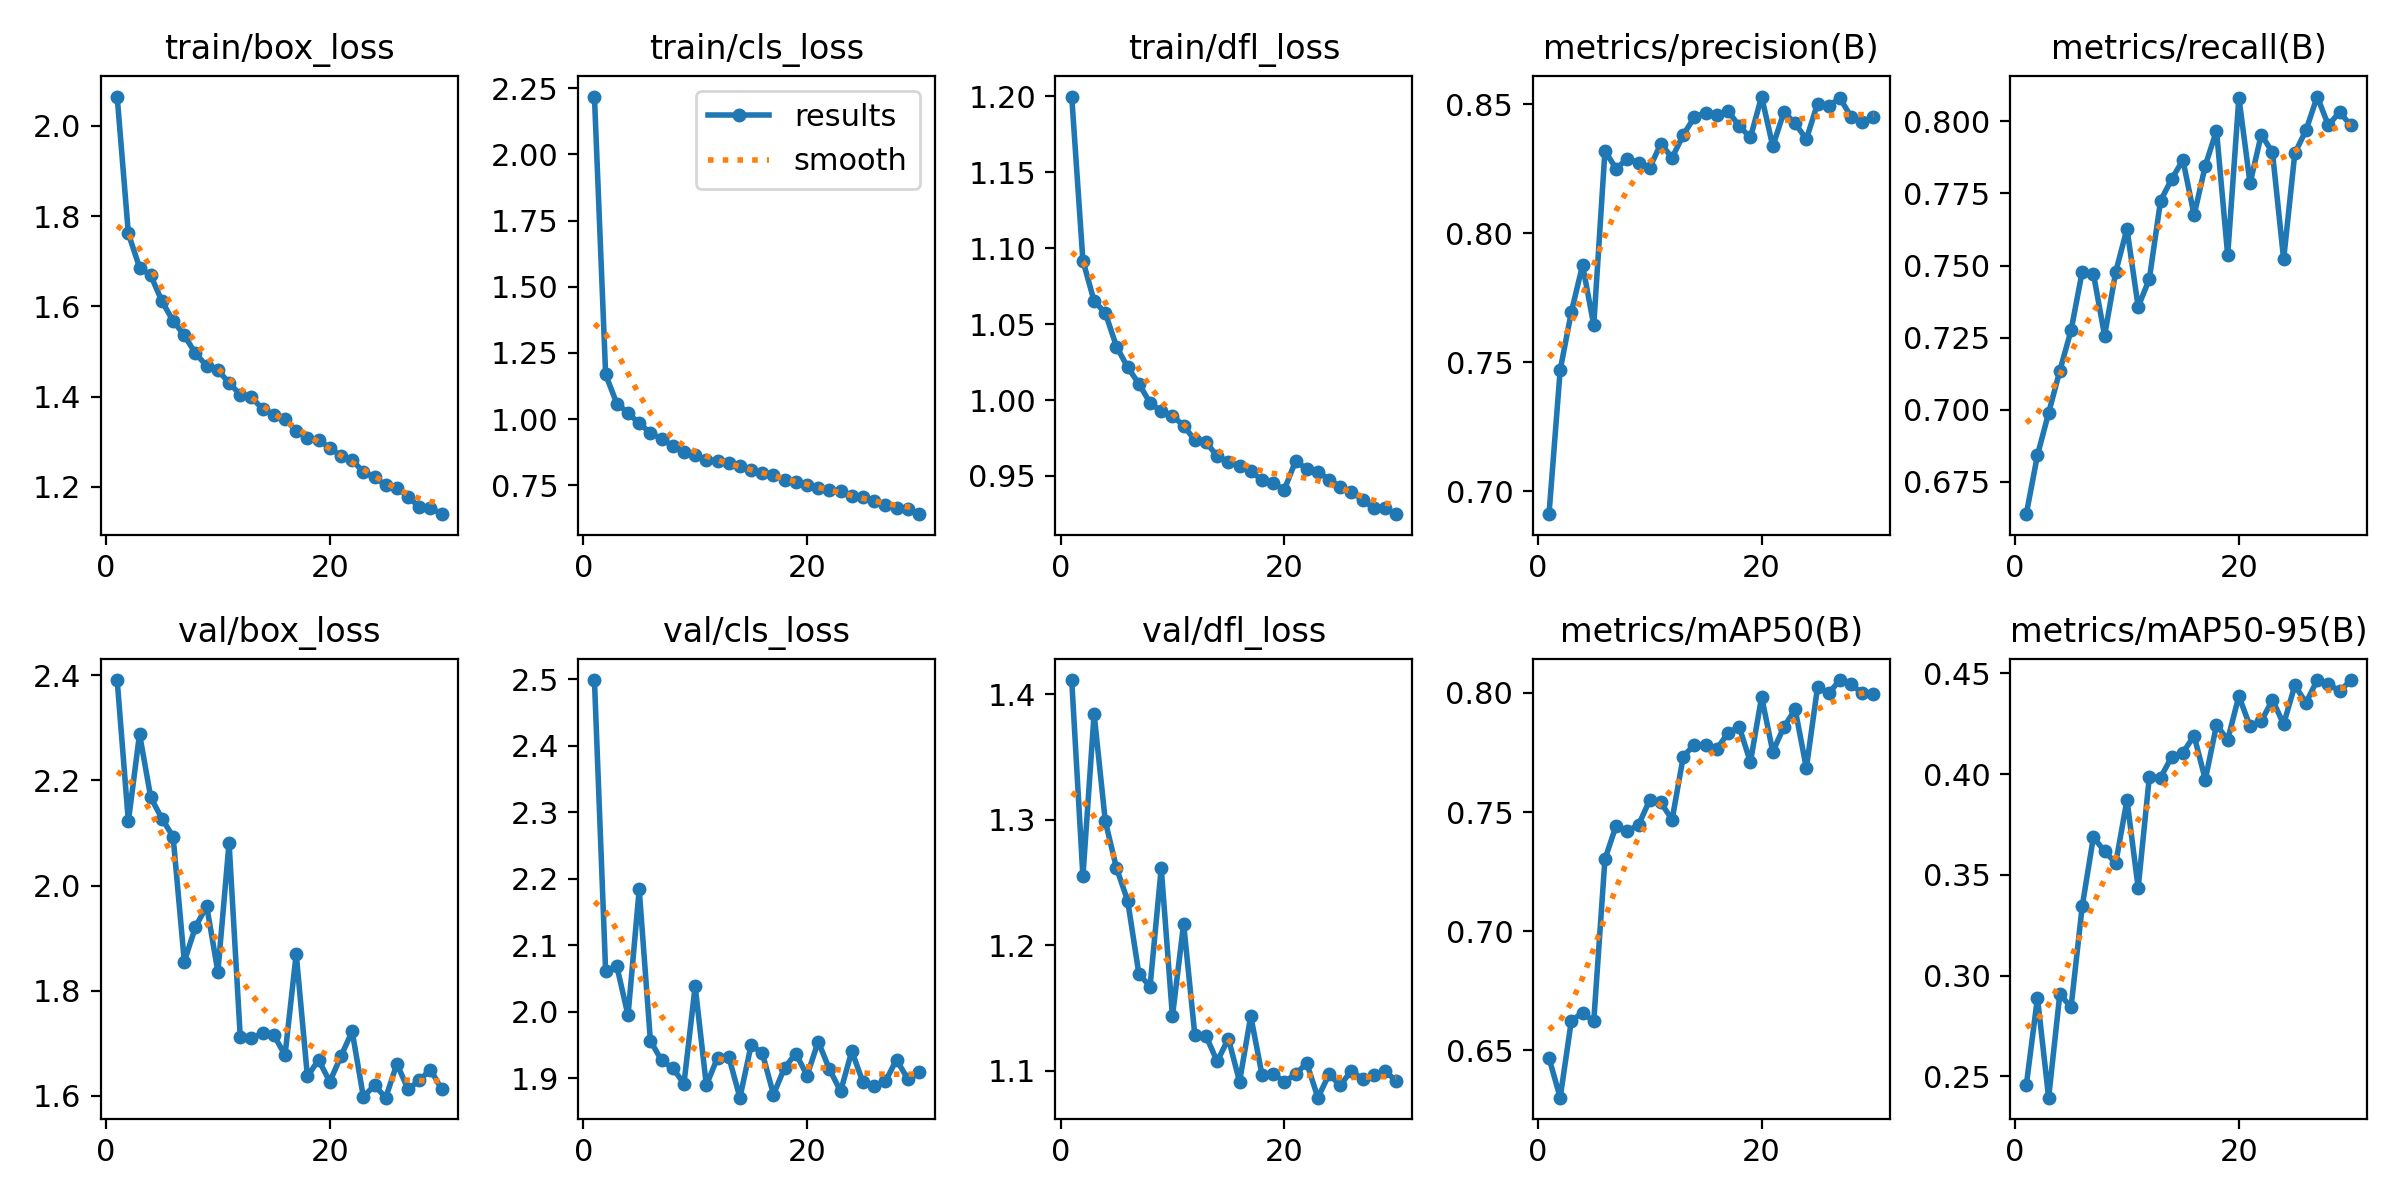

In [ ]:
from IPython.display import Image
Image(filename='runs/detect/train45/results.png')


# Run Object Detection

In [ ]:
from ultralytics import YOLO
print("loading")
model = YOLO("best.pt")
print("loaded sucessfully")
print(model.names)
result = model.predict(
    source="training/training01.mp4",  # dein Input-Video
    # source="leaderboard_data/test005.mp4",
    conf=0.25,                         # Konfidenzschwelle
    save=True,                         # speichert automatisch das Video mit Bounding Boxes
    save_txt=True,                    # kein TXT-Export (kannst du auch auf True setzen)
    stream=False                       # nötig, damit alles im Speicher bleibt und Video gespeichert wird
)
print(f"Ergebnisvideo gespeichert unter: {result[0].save_dir}")


loading
loaded sucessfully
{0: 'hexbug'}

WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/101) /home/hpc/tovl/tovl100v/traco_2024/training/training01.mp4: 480x640 1 hexbug, 9.9ms
video 1/1 (frame 2/101) /home/hpc/tovl/tovl100v/traco_2024/training/training01.mp4: 480x640 1 hexbug, 9.6ms
video 1/1 (frame 3/101) /home/hpc/tovl/tovl100v/traco_2024/training/training01.mp4: 480x640 1 hexbug, 9.4ms
video 1/1 (frame 4/101) /home/hpc/tovl/tovl100v/traco_2024/training/training01.mp4: 480x640

# Own Trakcing Kalman

In [ ]:
import cv2
import torch
import numpy as np
from scipy.optimize import linear_sum_assignment
import os
from ultralytics import YOLO

# --- Kalman-Filter & Tracker Classes ---

class KalmanFilter:
    def __init__(self, x, y):
        self.dt = 1.0
        self.A = np.array([[1, 0, self.dt, 0],
                           [0, 1, 0, self.dt],
                           [0, 0, 1, 0],
                           [0, 0, 0, 1]])
        self.H = np.array([[1, 0, 0, 0],
                           [0, 1, 0, 0]])
        self.x = np.array([x, y, 0, 0], dtype=float)
        self.P = np.eye(4) * 500
        self.Q = np.eye(4)
        self.R = np.eye(2) * 10

    def predict(self):
        self.x = self.A @ self.x
        self.P = self.A @ self.P @ self.A.T + self.Q

    def update(self, z):
        z = np.array(z)
        y = z - self.H @ self.x
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        self.P = (np.eye(4) - K @ self.H) @ self.P

    def get_position(self):
        return self.x[0], self.x[1]

class Track:
    def __init__(self, bbox, track_id):
        x, y = (bbox[0] + bbox[2]) / 2, (bbox[1] + bbox[3]) / 2
        self.kf = KalmanFilter(x, y)
        self.bbox = bbox
        self.track_id = track_id
        self.skipped_frames = 0

    def predict(self):
        self.kf.predict()
        return self.kf.get_position()

    def update(self, bbox):
        x, y = (bbox[0] + bbox[2]) / 2, (bbox[1] + bbox[3]) / 2
        self.kf.update([x, y])
        self.bbox = bbox
        self.skipped_frames = 0

def euclidean_distance(track, detection):
    tx, ty = track.kf.get_position()
    dx = (detection[0] + detection[2]) / 2
    dy = (detection[1] + detection[3]) / 2
    return np.linalg.norm([tx - dx, ty - dy])

def assign_detections_to_tracks(tracks, detections, max_distance=50):
    if len(tracks) == 0:
        return [], list(range(len(detections))), []

    cost_matrix = np.zeros((len(tracks), len(detections)), dtype=np.float32)
    for t, track in enumerate(tracks):
        for d, det in enumerate(detections):
            cost_matrix[t, d] = euclidean_distance(track, det)

    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    assignments = []
    unmatched_tracks = list(range(len(tracks)))
    unmatched_detections = list(range(len(detections)))

    for r, c in zip(row_ind, col_ind):
        if cost_matrix[r, c] > max_distance:
            continue
        assignments.append((r, c))
        unmatched_tracks.remove(r)
        unmatched_detections.remove(c)

    return assignments, unmatched_detections, unmatched_tracks

class Tracker:
    def __init__(self, max_skipped_frames=5):
        self.tracks = []
        self.next_id = 0
        self.max_skipped_frames = max_skipped_frames

    def update(self, detections):
        # Predict all tracks
        for track in self.tracks:
            track.predict()

        # Associate detections to tracks
        assignments, unmatched_dets, unmatched_trks = assign_detections_to_tracks(self.tracks, detections)

        # Update assigned tracks
        for trk_idx, det_idx in assignments:
            self.tracks[trk_idx].update(detections[det_idx])

        # Create new tracks for unmatched detections
        for idx in unmatched_dets:
            self.tracks.append(Track(detections[idx], self.next_id))
            self.next_id += 1

        # Increase skipped frames count for unmatched tracks
        for idx in unmatched_trks:
            self.tracks[idx].skipped_frames += 1

        # Remove lost tracks
        self.tracks = [t for t in self.tracks if t.skipped_frames <= self.max_skipped_frames]

    def get_tracks(self):
        return [(t.track_id, t.bbox) for t in self.tracks]

# --- Hauptprogramm ---


import os
import cv2
from ultralytics import YOLO

def main(video_path):
    os.makedirs('results_csv', exist_ok=True)

    model = YOLO("best.pt")
    tracker = Tracker(max_skipped_frames=5)  # Nur dieses Argument, keine extra Parameter

    cap = cv2.VideoCapture(video_path)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    out = cv2.VideoWriter('results_csv/output_tracking3.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    frame_id = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # YOLO Detection (normalisierte Boxen: x_center, y_center, width, height)
        detections = []
        results = model(frame)
        img_h, img_w = frame.shape[:2]

        for result in results:
            boxes = result.boxes
            if boxes is None:
                continue
            for box in boxes:
                x_c, y_c, w, h = box.xywh[0].cpu().numpy()
                detections.append([x_c/img_w, y_c/img_h, w/img_w, h/img_h])

        # Tracker updaten und get_tracks aufrufen
        tracker.update(detections)
        tracked_objects = tracker.get_tracks()

        # Visualisierung der Tracks
        for track_id, bbox in tracked_objects:
            x_c, y_c, bw, bh = bbox
            x1 = int((x_c - bw/2) * img_w)
            y1 = int((y_c - bh/2) * img_h)
            x2 = int((x_c + bw/2) * img_w)
            y2 = int((y_c + bh/2) * img_h)

            color = (int(track_id*37)%255, int(track_id*17)%255, int(track_id*29)%255)
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
            cv2.putText(frame, f'ID {track_id}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        cv2.putText(frame, f"Frame: {frame_id}", (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
        out.write(frame)

        frame_id += 1

    cap.release()
    out.release()
    cv2.destroyAllWindows()
    print(f"✅ Tracking fertig, Video gespeichert: results_csv/output_tracking.mp4")


if __name__ == "__main__":
    main('training/training065.mp4')








0: 640x480 2 hexbugs, 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 2 hexbugs, 9.6ms
Speed: 5.9ms preprocess, 9.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 2 hexbugs, 8.7ms
Speed: 3.3ms preprocess, 8.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 2 hexbugs, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 2 hexbugs, 7.3ms
Speed: 2.6ms preprocess, 7.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 2 hexbugs, 7.3ms
Speed: 2.6ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 2 hexbugs, 7.3ms
Speed: 2.7ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 2 hexbugs, 7.6ms
Speed: 2.6ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


# temporal mean background subtraction

In [ ]:
import cv2
import numpy as np
import os

def temporal_mean_background_subtraction(video_path, num_frames=50):
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    mean_frame = None
    processed_frames = 0

    for i in range(min(num_frames, frame_count)):
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY).astype(np.float32)

        if mean_frame is None:
            mean_frame = gray
        else:
            mean_frame += gray

        processed_frames += 1

    cap.release()

    if processed_frames == 0:
        raise ValueError("Keine Frames gelesen.")

    mean_frame /= processed_frames
    mean_frame = mean_frame.astype(np.uint8)

    return mean_frame

def create_colored_foreground_video(input_video_path, output_video_path, background, threshold=30):
    cap = cv2.VideoCapture(input_video_path)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height), isColor=True)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        fg_mask = cv2.absdiff(gray, background)
        _, binary_mask = cv2.threshold(fg_mask, threshold, 255, cv2.THRESH_BINARY)

        # Apply the mask to the color frame
        colored_foreground = cv2.bitwise_and(frame, frame, mask=binary_mask)

        out.write(colored_foreground)

    cap.release()
    out.release()
    print(f"🎨 Farb-Vordergrundvideo gespeichert: {output_video_path}")

if __name__ == "__main__":
    input_path = 'training/training034.mp4'
    output_path = 'results_csv/colored_foreground_output34.mp4'

    os.makedirs('results_csv', exist_ok=True)

    bg = temporal_mean_background_subtraction(input_path, num_frames=100)
    create_colored_foreground_video(input_path, output_path, bg, threshold=30)


🎨 Farb-Vordergrundvideo gespeichert: results_csv/colored_foreground_output34.mp4


# mit histogram farbe

In [ ]:
import cv2
import torch
import numpy as np
from scipy.optimize import linear_sum_assignment
import os
from ultralytics import YOLO

# --- Kalman-Filter & Tracker Klassen ---

class KalmanFilter:
    def __init__(self, x, y):
        self.dt = 1.0
        self.A = np.array([[1, 0, self.dt, 0],
                           [0, 1, 0, self.dt],
                           [0, 0, 1, 0],
                           [0, 0, 0, 1]])
        self.H = np.array([[1, 0, 0, 0],
                           [0, 1, 0, 0]])
        self.x = np.array([x, y, 0, 0], dtype=float)
        self.P = np.eye(4) * 500
        self.Q = np.eye(4)
        self.R = np.eye(2) * 10

    def predict(self):
        self.x = self.A @ self.x
        self.P = self.A @ self.P @ self.A.T + self.Q

    def update(self, z):
        z = np.array(z)
        y = z - self.H @ self.x
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        self.P = (np.eye(4) - K @ self.H) @ self.P

    def get_position(self):
        return self.x[0], self.x[1]

def extract_histogram(frame, bbox):
    x_c, y_c, w, h = bbox
    h_img, w_img = frame.shape[:2]

    x1 = int((x_c - w/2) * w_img)
    y1 = int((y_c - h/2) * h_img)
    x2 = int((x_c + w/2) * w_img)
    y2 = int((y_c + h/2) * h_img)

    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(w_img, x2), min(h_img, y2)

    roi = frame[y1:y2, x1:x2]
    if roi.size == 0:
        return np.zeros((256,), dtype=np.float32)

    hist = cv2.calcHist([roi], [0], None, [256], [0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

class Track:
    def __init__(self, bbox, track_id, frame):
        x, y = (bbox[0] + bbox[2]) / 2, (bbox[1] + bbox[3]) / 2
        self.kf = KalmanFilter(x, y)
        self.bbox = bbox
        self.track_id = track_id
        self.skipped_frames = 0
        self.appearance = extract_histogram(frame, bbox)

    def predict(self):
        self.kf.predict()
        return self.kf.get_position()

    def update(self, bbox, frame):
        x, y = (bbox[0] + bbox[2]) / 2, (bbox[1] + bbox[3]) / 2
        self.kf.update([x, y])
        self.bbox = bbox
        self.skipped_frames = 0
        self.appearance = extract_histogram(frame, bbox)

def euclidean_distance(track, detection):
    tx, ty = track.kf.get_position()
    dx = (detection[0] + detection[2]) / 2
    dy = (detection[1] + detection[3]) / 2
    return np.linalg.norm([tx - dx, ty - dy])

def compute_appearance_cost(track_hist, det_hist):
    return cv2.compareHist(track_hist.astype(np.float32), det_hist.astype(np.float32), cv2.HISTCMP_BHATTACHARYYA)

def assign_detections_to_tracks(tracks, detections, frame, max_distance=0.7):
    if len(tracks) == 0:
        return [], list(range(len(detections))), []

    det_histograms = [extract_histogram(frame, det) for det in detections]

    cost_matrix = np.zeros((len(tracks), len(detections)), dtype=np.float32)
    for t, track in enumerate(tracks):
        for d, det in enumerate(detections):
            dist_cost = euclidean_distance(track, det)
            app_cost = compute_appearance_cost(track.appearance, det_histograms[d])
            cost_matrix[t, d] = 0.5 * dist_cost + 0.5 * app_cost

    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    assignments = []
    unmatched_tracks = list(range(len(tracks)))
    unmatched_detections = list(range(len(detections)))

    for r, c in zip(row_ind, col_ind):
        if cost_matrix[r, c] > max_distance:
            continue
        assignments.append((r, c))
        unmatched_tracks.remove(r)
        unmatched_detections.remove(c)

    return assignments, unmatched_detections, unmatched_tracks

class Tracker:
    def __init__(self, max_skipped_frames=5):
        self.tracks = []
        self.next_id = 0
        self.max_skipped_frames = max_skipped_frames

    def update(self, detections, frame):
        for track in self.tracks:
            track.predict()

        assignments, unmatched_dets, unmatched_trks = assign_detections_to_tracks(self.tracks, detections, frame)

        for trk_idx, det_idx in assignments:
            self.tracks[trk_idx].update(detections[det_idx], frame)

        for idx in unmatched_dets:
            self.tracks.append(Track(detections[idx], self.next_id, frame))
            self.next_id += 1

        for idx in unmatched_trks:
            self.tracks[idx].skipped_frames += 1

        self.tracks = [t for t in self.tracks if t.skipped_frames <= self.max_skipped_frames]

    def get_tracks(self):
        return [(t.track_id, t.bbox) for t in self.tracks]

# --- Hauptprogramm ---

def main(video_path):
    os.makedirs('results_csv', exist_ok=True)

    model = YOLO("best.pt")
    tracker = Tracker(max_skipped_frames=5)

    cap = cv2.VideoCapture(video_path)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    out = cv2.VideoWriter('results_csv/output_tracking.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    frame_id = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        detections = []
        results = model(frame)
        img_h, img_w = frame.shape[:2]

        for result in results:
            boxes = result.boxes
            if boxes is None:
                continue
            for box in boxes:
                x_c, y_c, w, h = box.xywh[0].cpu().numpy()
                detections.append([x_c/img_w, y_c/img_h, w/img_w, h/img_h])

        tracker.update(detections, frame)
        tracked_objects = tracker.get_tracks()

        for track_id, bbox in tracked_objects:
            x_c, y_c, bw, bh = bbox
            x1 = int((x_c - bw/2) * img_w)
            y1 = int((y_c - bh/2) * img_h)
            x2 = int((x_c + bw/2) * img_w)
            y2 = int((y_c + bh/2) * img_h)

            color = (int(track_id*37)%255, int(track_id*17)%255, int(track_id*29)%255)
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
            cv2.putText(frame, f'ID {track_id}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        cv2.putText(frame, f"Frame: {frame_id}", (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
        out.write(frame)

        frame_id += 1

    cap.release()
    out.release()
    cv2.destroyAllWindows()
    print(f"✅ Tracking fertig, Video gespeichert: results_csv/output_tracking.mp4")

if __name__ == "__main__":
    # main('training/training034.mp4')
    main('results_csv/colored_foreground_output34.mp4')



0: 640x416 5 hexbugs, 41.7ms
Speed: 4.2ms preprocess, 41.7ms inference, 159.2ms postprocess per image at shape (1, 3, 640, 416)

0: 640x416 3 hexbugs, 7.0ms
Speed: 2.6ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)

0: 640x416 5 hexbugs, 9.1ms
Speed: 2.9ms preprocess, 9.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 416)

0: 640x416 7 hexbugs, 9.2ms
Speed: 2.8ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 416)

0: 640x416 6 hexbugs, 9.4ms
Speed: 2.9ms preprocess, 9.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 416)

0: 640x416 6 hexbugs, 9.4ms
Speed: 2.8ms preprocess, 9.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 416)

0: 640x416 5 hexbugs, 9.3ms
Speed: 2.8ms preprocess, 9.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 416)

0: 640x416 3 hexbugs, 9.2ms
Speed: 2.9ms preprocess, 9.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 4

# Tracking - DeepSort

In [4]:
import cv2
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort

# 1. YOLO Modell laden
model = YOLO("best.pt")

# 2. Deep SORT Tracker initialisieren
tracker = DeepSort(max_age=30)

# 3. Video laden
# video_path = "training/training01.mp4"
video_path = "/content/drive/MyDrive/traco_2024/training/training01.mp4"
cap = cv2.VideoCapture(video_path)

# Video-Writer initialisieren
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # mp4 Codec
fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter('output_tracked.mp4', fourcc, fps, (frame_width, frame_height))

while True:
    ret, frame = cap.read()
    if not ret:
        break

    img_h, img_w = frame.shape[:2]

    # 4. YOLO Inferenz
    results = model(frame)

    detections = []
    for r in results:
        boxes = r.boxes.xywhn.cpu().numpy()
        scores = r.boxes.conf.cpu().numpy()
        classes = r.boxes.cls.cpu().numpy()

        for box, score, cls in zip(boxes, scores, classes):
            if score < 0.3:
                continue
            print(box)
            x_c, y_c, w_n, h_n = box
            x_min = int((x_c - w_n / 2) * img_w)
            y_min = int((y_c - h_n / 2) * img_h)
            w_px = int(w_n * img_w)
            h_px = int(h_n * img_h)

            detections.append(([x_min, y_min, w_px, h_px], score, int(cls)))

    tracks = tracker.update_tracks(detections, frame=frame)


    # 6. Visualisieren der Tracks mit IDs
    for track in tracks:
        if not track.is_confirmed():
            continue

        l, t, r, b = track.to_ltrb()
        l, t, r, b = map(int, (l, t, r, b))
        track_id = track.track_id

        cv2.rectangle(frame, (l, t), (r, b), (0, 255, 0), 2)
        cv2.putText(frame, f"ID: {track_id}", (l, t - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    # Frame ins Ausgabevideo schreiben
    out.write(frame)

cap.release()
out.release()
cv2.destroyAllWindows()


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.

0: 480x640 1 hexbug, 1139.5ms
Speed: 15.2ms preprocess, 1139.5ms inference, 38.1ms postprocess per image at shape (1, 3, 480, 640)
[    0.22544     0.68917    0.048567    0.055355]

0: 480x640 1 hexbug, 765.3ms
Speed: 5.4ms preprocess, 765.3ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 640)
[    0.22541     0.68917     0.04862    0.055432]

0: 480x640 1 hexbug, 346.3ms
Speed: 5.9ms preprocess, 346.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)
[    0.26902     0.62147    0.048667    0.055887]

0: 480x640 1 hexbug, 666.5ms
Speed: 43.4ms preprocess, 666.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)
[    0.31294      0.56

In [5]:
import cv2
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort

model = YOLO("best.pt")
tracker = DeepSort(max_age=30)


cap = cv2.VideoCapture("/content/drive/MyDrive/traco_2024/training/training01.mp4")


fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = cap.get(cv2.CAP_PROP_FPS)
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter('output_tracked.mp4', fourcc, fps, (w, h))

while True:
    ret, frame = cap.read()
    if not ret:
        break

    img_h, img_w = frame.shape[:2]

    results = model(frame)

    detections = []
    for r in results:
        boxes = r.boxes.xywhn.cpu().numpy()  # Normalisierte xywh
        scores = r.boxes.conf.cpu().numpy()
        classes = r.boxes.cls.cpu().numpy()

        for box, score, cls in zip(boxes, scores, classes):
            if score < 0.3:
                continue

            x_c_norm, y_c_norm, w_norm, h_norm = box

            # Normalisierte xywh auf Pixel umrechnen
            x_c = x_c_norm * img_w
            y_c = y_c_norm * img_h
            w_box = w_norm * img_w
            h_box = h_norm * img_h

            # Von (x_center, y_center, width, height) zu (left, top, right, bottom)
            left = int(x_c - w_box / 2)
            top = int(y_c - h_box / 2)
            right = int(x_c + w_box / 2)
            bottom = int(y_c + h_box / 2)

            # Wichtig: Falls Koordinaten außerhalb des Bildes sind, begrenzen
            left = max(0, left)
            top = max(0, top)
            right = min(img_w - 1, right)
            bottom = min(img_h - 1, bottom)

            detections.append(([left, top, right, bottom], float(score), int(cls)))

    tracks = tracker.update_tracks(detections, frame=frame)

    for track in tracks:
        if not track.is_confirmed():
            continue

        l, t, r, b = map(int, track.to_ltrb())
        track_id = track.track_id

        cv2.rectangle(frame, (l, t), (r, b), (0, 255, 0), 2)
        cv2.putText(frame, f"ID: {track_id}", (l, t - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    out.write(frame)

cap.release()
out.release()
cv2.destroyAllWindows()



0: 480x640 1 hexbug, 184.8ms
Speed: 4.6ms preprocess, 184.8ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 hexbug, 169.6ms
Speed: 4.7ms preprocess, 169.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 hexbug, 156.5ms
Speed: 5.2ms preprocess, 156.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 hexbug, 179.1ms
Speed: 11.5ms preprocess, 179.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 hexbug, 184.0ms
Speed: 5.2ms preprocess, 184.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 hexbug, 166.9ms
Speed: 4.1ms preprocess, 166.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 hexbug, 177.4ms
Speed: 5.7ms preprocess, 177.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 hexbug, 181.6ms
Speed: 5.2ms preprocess, 181.6ms inference, 1.3ms postprocess per image a

In [ ]:
import cv2
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort

model = YOLO("best.pt")
tracker = DeepSort(max_age=30)

cap = cv2.VideoCapture("training/training01.mp4")

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter('output_tracked.mp4', fourcc, fps, (frame_width, frame_height))

while True:
    ret, frame = cap.read()
    if not ret:
        break

    img_h, img_w = frame.shape[:2]
    results = model(frame)

    detections = []
    for r in results:
        boxes = r.boxes.xywhn.cpu().numpy()
        scores = r.boxes.conf.cpu().numpy()
        classes = r.boxes.cls.cpu().numpy()

        for box, score, cls in zip(boxes, scores, classes):
            if score < 0.3:
                continue
            print(box)
            x_c, y_c, w_n, h_n = box
            x_min = int((x_c - w_n / 2) * img_w)
            y_min = int((y_c - h_n / 2) * img_h)
            w_px = int(w_n * img_w)
            h_px = int(h_n * img_h)

            detections.append(([x_min, y_min, w_px, h_px], score, int(cls)))

    tracks = tracker.update_tracks(detections, frame=frame)
    print(f"Anzahl Tracks: {len(tracks)}")

    for track in tracks:
        if not track.is_confirmed():
            continue
        l, t, r, b = map(int, track.to_ltrb())
        track_id = track.track_id
        print(f"Track ID {track_id}: bbox=({l},{t},{r},{b})")  # Check, ob Koordinaten sinnvoll sind

        # Zeichne auffällige rote Boxen
        cv2.rectangle(frame, (l, t), (r, b), (0, 0, 255), 3)
        cv2.putText(frame, f"ID: {track_id}", (l, t - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)


    out.write(frame)

cap.release()
out.release()
cv2.destroyAllWindows()



0: 480x640 1 hexbug, 7.4ms
Speed: 2.2ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)
[    0.22544     0.68917    0.048567    0.055355]
Anzahl Tracks: 1

0: 480x640 1 hexbug, 6.9ms
Speed: 2.4ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)
[    0.22541     0.68917     0.04862    0.055432]
Anzahl Tracks: 1

0: 480x640 1 hexbug, 7.0ms
Speed: 2.5ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)
[    0.26902     0.62147    0.048667    0.055887]
Anzahl Tracks: 1

0: 480x640 1 hexbug, 6.9ms
Speed: 2.4ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)
[    0.31294      0.5678    0.048512    0.055776]
Anzahl Tracks: 1

0: 480x640 1 hexbug, 6.8ms
Speed: 2.4ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)
[     0.3675     0.54527    0.046954    0.053852]
Anzahl Tracks: 1

0: 480x640 1 hexbug, 8.9ms
Speed: 3.0ms prep

In [ ]:
import cv2
import numpy as np
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort

# 1. YOLO Modell laden
model = YOLO("best.pt")

# 2. Deep SORT Tracker initialisieren
tracker = DeepSort(max_age=30)

# 3. Video laden
video_path = "training/training01.mp4"
cap = cv2.VideoCapture(video_path)

# Video-Writer initialisieren
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec für mp4
fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter('output_tracked.mp4', fourcc, fps, (frame_width, frame_height))

while True:
    ret, frame = cap.read()
    if not ret:
        break

    img_h, img_w = frame.shape[:2]

    # 4. YOLO Inferenz
    results = model(frame)

    detections = []
    for r in results:
        boxes = r.boxes.xywhn.cpu().numpy()  # normalized x_center, y_center, width, height
        scores = r.boxes.conf.cpu().numpy()
        classes = r.boxes.cls.cpu().numpy()

        for box, score, cls in zip(boxes, scores, classes):
            if score < 0.3:
                continue

            x_c, y_c, w_n, h_n = box
            x_min = int((x_c - w_n / 2) * img_w)
            y_min = int((y_c - h_n / 2) * img_h)
            w_px = int(w_n * img_w)
            h_px = int(h_n * img_h)

            detections.append(([x_min, y_min, w_px, h_px], score, int(cls)))

    # 5. Deep SORT Tracking aufrufen
    tracks = tracker.update_tracks(detections, frame=frame)

    # 6. Visualisieren
    for track in tracks:
        if not track.is_confirmed():
            continue

        track_id = track.track_id
        l, t, r, b = track.to_ltrb()  # left, top, right, bottom
        l, t, r, b = int(l), int(t), int(r), int(b)

        cv2.rectangle(frame, (l, t), (r, b), (0, 255, 0), 2)
        cv2.putText(frame, f"ID: {track_id}", (l, t - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)


    # Frame ins Video schreiben
    out.write(frame)


cap.release()
out.release()  # Wichtig: VideoWriter freigeben!
cv2.destroyAllWindows()



0: 480x640 1 hexbug, 9.1ms
Speed: 2.9ms preprocess, 9.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 hexbug, 7.0ms
Speed: 2.4ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 hexbug, 6.8ms
Speed: 2.5ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 hexbug, 6.8ms
Speed: 2.5ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 hexbug, 6.8ms
Speed: 2.4ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 hexbug, 6.9ms
Speed: 2.4ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 hexbug, 6.8ms
Speed: 2.4ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 hexbug, 6.8ms
Speed: 2.4ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x

In [ ]:
import cv2
import numpy as np
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort

# 1. YOLO Modell laden
model = YOLO("best.pt")

# 2. Deep SORT Tracker initialisieren
tracker = DeepSort(max_age=30)  # optional Parameter anpassen

# 3. Video laden
video_path = "training/training01.mp4"
cap = cv2.VideoCapture(video_path)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    img_h, img_w = frame.shape[:2]

    # 4. YOLO Inferenz
    results = model(frame)

    detections = []
    for r in results:
        boxes = r.boxes.xywhn.cpu().numpy()  # normalized x_center, y_center, width, height
        scores = r.boxes.conf.cpu().numpy()
        classes = r.boxes.cls.cpu().numpy()

        for box, score, cls in zip(boxes, scores, classes):
            if score < 0.3:
                continue

            x_c, y_c, w_n, h_n = box
            x_min = int((x_c - w_n / 2) * img_w)
            y_min = int((y_c - h_n / 2) * img_h)
            w_px = int(w_n * img_w)
            h_px = int(h_n * img_h)

            detections.append(([x_min, y_min, w_px, h_px], score, int(cls)))

    # 5. Deep SORT Tracking aufrufen
    tracks = tracker.update_tracks(detections, frame=frame)

    # 6. Visualisieren
    for track in tracks:
        if not track.is_confirmed():
            continue

        track_id = track.track_id
        l, t, w, h = track.to_ltrb()  # left, top, right, bottom
        l, t, r, b = int(l), int(t), int(w), int(h)

        cv2.rectangle(frame, (l, t), (r, b), (0, 255, 0), 2)
        cv2.putText(frame, f"ID: {track_id}", (l, t - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)


cap.release()
cv2.destroyAllWindows()



0: 480x640 1 hexbug, 46.3ms
Speed: 3.2ms preprocess, 46.3ms inference, 249.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 hexbug, 6.8ms
Speed: 6.6ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 hexbug, 8.7ms
Speed: 3.6ms preprocess, 8.7ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 hexbug, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 hexbug, 8.0ms
Speed: 4.9ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 hexbug, 6.7ms
Speed: 2.6ms preprocess, 6.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 hexbug, 6.6ms
Speed: 2.5ms preprocess, 6.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 hexbug, 8.4ms
Speed: 4.6ms preprocess, 8.4ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 

In [ ]:
import os
import cv2
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort

def iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = max(0, boxA[2] - boxA[0]) * max(0, boxA[3] - boxA[1])
    boxBArea = max(0, boxB[2] - boxB[0]) * max(0, boxB[3] - boxB[1])
    if boxAArea + boxBArea - interArea == 0:
        return 0
    return interArea / float(boxAArea + boxBArea - interArea)

video_path = "training/training01.mp4"
os.makedirs("results_csv", exist_ok=True)

# YOLO-Modell laden
yolo = YOLO("best.pt")

# DeepSort initialisieren
tracker = DeepSort(
    max_age=50,
    n_init=3,
    embedder="mobilenet",
    max_iou_distance=0.7,
    max_cosine_distance=0.4
)

cap = cv2.VideoCapture(video_path)

# VideoWriter vorbereiten (vor der Schleife)
output_path = "results_csv/output_with_tracking.mp4"
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out_video = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))
print("width")
print(frame_width)
print("height")
print(frame_height)

frame_idx = 0
last_bboxes = {}

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_idx += 1
    print(f"\n=== Frame {frame_idx} ===")

    height, width = frame.shape[:2]

    results = yolo.predict(frame, verbose=False)
    result = results[0]

    # YOLO gibt normierte xywh Boxen zurück
    boxes_yolo = result.boxes.xywh.cpu().numpy()  # [x_center, y_center, w, h] normiert
    confidences = result.boxes.conf.cpu().numpy()
    classes = result.boxes.cls.cpu().numpy()

    dets_for_deepsort = []

    print("Detections (BBox + Conf):")
    for box, conf, cls in zip(boxes_yolo, confidences, classes):
        if cls != 0:
            continue

        print(box)
        x_center, y_center, w_norm, h_norm = box
        # w_pix = w_norm * width
        # h_pix = h_norm * height

        x1 = int(x_center - w_norm / 2)
        y1 = int(y_center - h_norm / 2)
        x2 = int(x_center + w_norm / 2)
        y2 = int(y_center + h_norm / 2)

        # # Filtere sehr kleine Boxen raus (optional)
        # if (x2 - x1) < 5 or (y2 - y1) < 5:
        #     continue

        dets_for_deepsort.append(([x1, y1, x2, y2], conf))
        print(f"  BBox: [{x1}, {y1}, {x2}, {y2}], Conf: {conf:.3f}")
    # print(dets_for_deepsort)
    tracks = tracker.update_tracks(dets_for_deepsort, frame=frame)

    print("Tracks nach Update:")
    for track in tracks:
        if not track.is_confirmed():
            print(f"  ID: {track.track_id} (unconfirmed), Age: {track.age}, Hits: {track.hits}")
            continue

        bbox = track.to_ltrb()
        print(f"  ID: {track.track_id}, BBox: [{bbox[0]:.1f}, {bbox[1]:.1f}, {bbox[2]:.1f}, {bbox[3]:.1f}]")

        last_bbox = last_bboxes.get(track.track_id)
        if last_bbox is not None:
            iou_val = iou(last_bbox, bbox)
            print(f"    IOU zum vorherigen Frame: {iou_val:.3f}")
        else:
            print("    Kein vorheriger BBox für IOU vorhanden")

        last_bboxes[track.track_id] = bbox

        # Zeichne Bounding Box und ID
        cv2.rectangle(frame, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 255, 0), 2)
        cv2.putText(frame, f'ID: {track.track_id}', (int(bbox[0]), int(bbox[1]) - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    out_video.write(frame)

cap.release()
out_video.release()
cv2.destroyAllWindows()


width
1024
height
768

=== Frame 1 ===
Detections (BBox + Conf):
[     230.85      529.28      49.733      42.513]
  BBox: [205, 508, 255, 550], Conf: 0.760
Tracks nach Update:
  ID: 1 (unconfirmed), Age: 1, Hits: 1

=== Frame 2 ===
Detections (BBox + Conf):
[     230.82      529.28      49.787      42.572]
  BBox: [205, 507, 255, 550], Conf: 0.760
Tracks nach Update:
  ID: 1 (unconfirmed), Age: 2, Hits: 2

=== Frame 3 ===
Detections (BBox + Conf):
[     275.48      477.29      49.835      42.921]
  BBox: [250, 455, 300, 498], Conf: 0.795
Tracks nach Update:
  ID: 1, BBox: [266.0, 466.4, 504.2, 975.9]
    Kein vorheriger BBox für IOU vorhanden

=== Frame 4 ===
Detections (BBox + Conf):
[     320.45      436.07      49.676      42.836]
  BBox: [295, 414, 345, 457], Conf: 0.793
Tracks nach Update:
  ID: 1, BBox: [343.9, 421.3, 566.0, 885.7]
    IOU zum vorherigen Frame: 0.427

=== Frame 5 ===
Detections (BBox + Conf):
[     376.32      418.76      48.081      41.358]
  BBox: [352, 398, 4

In [ ]:
import os
import cv2
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort

# Beispielumwandlung von [cx, cy, w, h] -> [x1, y1, x2, y2]
def xywh_to_xyxy(bbox):
    cx, cy, w, h = bbox
    x1 = cx - w / 2
    y1 = cy - h / 2
    x2 = cx + w / 2
    y2 = cy + h / 2
    return [x1, y1, x2, y2]

def iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interWidth = max(0, xB - xA)
    interHeight = max(0, yB - yA)
    interArea = interWidth * interHeight

    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    if boxAArea + boxBArea - interArea == 0:
        return 0

    return interArea / float(boxAArea + boxBArea - interArea)

video_paths = ["training/training01.mp4"]
os.makedirs("results_csv", exist_ok=True)

yolo = YOLO("best.pt")

tracker = DeepSort(
    max_age=50,
    n_init=3,
    embedder="mobilenet",
    max_iou_distance=0.7,
    max_cosine_distance=0.4
)

cap = cv2.VideoCapture(video_paths[0])
frame_idx = 0
last_bboxes = {}

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_idx += 1
    print(f"\n=== Frame {frame_idx} ===")

    height, width = frame.shape[:2]

    results = yolo.predict(frame)
    result = results[0]

    boxes = result.boxes.xyxy.cpu().numpy()       # [x1, y1, x2, y2]
    confidences = result.boxes.conf.cpu().numpy()

    dets_for_deepsort = []
    print("Detections (BBox + Conf):")
    for bbox, conf in zip(boxes, confidences):
        x1, y1, x2, y2 = bbox
        x1 = max(0, x1)
        y1 = max(0, y1)
        x2 = min(width - 1, x2)
        y2 = min(height - 1, y2)

        if x2 <= x1 or y2 <= y1:
            continue

        dets_for_deepsort.append(([x1, y1, x2, y2], conf))
        print(f"  BBox: [{x1:.1f}, {y1:.1f}, {x2 - x1:.1f}, {y2 - y1:.1f}], Conf: {conf:.3f}")

    # DeepSort update_tracks erwartet Liste von (bbox, score)

    tracks = tracker.update_tracks(dets_for_deepsort, frame=frame)

    print("Tracks nach Update:")
    for track in tracks:
        if not track.is_confirmed():
            print(f"  ID: {track.track_id}, Confirmed: False, Age: {track.age}, Hits: {track.hits}, BBox: {track.to_ltrb()}, Features length: {len(getattr(track, 'features', []))}")
            print("    -> Track nicht bestätigt (noch zu wenig Hits)")
            continue

        bbox = track.to_ltrb()
        print(f"  ID: {track.track_id}, Confirmed: True, Age: {track.age}, Hits: {track.hits}, BBox: [{bbox[0]:.1f}, {bbox[1]:.1f}, {bbox[2]:.1f}, {bbox[3]:.1f}], Features length: {len(getattr(track, 'features', []))}")

        last_bbox = last_bboxes.get(track.track_id)
        if last_bbox is not None:
            iou_val = iou(last_bbox, bbox)
            print(f"    IOU zu letztem Frame: {iou_val:.3f}")
        else:
            print("    Kein vorheriger BBox für IOU vorhanden")


        last_bboxes[track.track_id] = bbox

        cv2.rectangle(frame, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 255, 0), 2)
        cv2.putText(frame, f'ID: {track.track_id}', (int(bbox[0]), int(bbox[1]) - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Optional Frame anzeigen (auskommentiert)
    # cv2.imshow("Tracking", frame)
    # if cv2.waitKey(1) & 0xFF == ord('q'):
    #     break

cap.release()
cv2.destroyAllWindows()



=== Frame 1 ===

0: 480x640 1 hexbug, 7.1ms
Speed: 2.1ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)
Detections (BBox + Conf):
  BBox: [206.0, 508.0, 49.7, 42.5], Conf: 0.760
Tracks nach Update:
  ID: 1, Confirmed: False, Age: 1, Hits: 1, BBox: [     205.98      508.02       461.7      1058.6], Features length: 1
    -> Track nicht bestätigt (noch zu wenig Hits)

=== Frame 2 ===

0: 480x640 1 hexbug, 6.8ms
Speed: 2.4ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)
Detections (BBox + Conf):
  BBox: [205.9, 508.0, 49.8, 42.6], Conf: 0.760
Tracks nach Update:
  ID: 1, Confirmed: False, Age: 2, Hits: 2, BBox: [     205.93         508      461.66      1058.6], Features length: 2
    -> Track nicht bestätigt (noch zu wenig Hits)

=== Frame 3 ===

0: 480x640 1 hexbug, 11.3ms
Speed: 2.9ms preprocess, 11.3ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)
Detections (BBox + Conf):
  BBox: [250.6, 455.8

In [ ]:
import os
import cv2
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort

video_paths = ["training/training01.mp4"]
output_dir = "results_csv"
os.makedirs(output_dir, exist_ok=True)

yolo = YOLO("best.pt")
tracker = DeepSort(max_age=50, n_init=1, embedder="mobilenet")

cap = cv2.VideoCapture(video_paths[0])

frame_idx = 0  # Frame-Zähler

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_idx += 1
    print(f"\n=== Frame {frame_idx} ===")

    # 1. Objektdetektion mit YOLO
    results = yolo.predict(frame)
    result = results[0]

    boxes = result.boxes.xyxy.cpu().numpy()
    confidences = result.boxes.conf.cpu().numpy()

    dets_for_deepsort = []
    print("Detections (BBox + Conf):")
    for bbox, conf in zip(boxes, confidences):
        x1, y1, x2, y2 = bbox
        left = x1
        top = y1
        width = x2 - x1
        height = y2 - y1
        dets_for_deepsort.append(([left, top, width, height], conf))
        print(f"  BBox: [{left:.1f}, {top:.1f}, {width:.1f}, {height:.1f}], Conf: {conf:.3f}")

    tracks = tracker.update_tracks(dets_for_deepsort, frame=frame)

    print("Tracks nach Update:")
    for track in tracks:
        bbox = track.to_ltrb()
        confirmed = track.is_confirmed()
        feature_len = len(track.features) if hasattr(track, 'features') and track.features is not None else 0
        print(f"  ID: {track.track_id}, Confirmed: {confirmed}, BBox: [{bbox[0]:.1f}, {bbox[1]:.1f}, {bbox[2]:.1f}, {bbox[3]:.1f}], Features length: {feature_len}")

        if not confirmed:
            print("    -> Track nicht bestätigt")
            continue

        # Bounding Box zeichnen
        cv2.rectangle(frame, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0,255,0), 2)
        cv2.putText(frame, f'ID: {track.track_id}', (int(bbox[0]), int(bbox[1]) - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)

    # Optional: Frame anzeigen, falls gewünscht
    # cv2.imshow("Tracking", frame)
    # if cv2.waitKey(1) & 0xFF == ord('q'):
    #     break

cap.release()
cv2.destroyAllWindows()



=== Frame 1 ===

0: 480x640 1 hexbug, 7.2ms
Speed: 2.2ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)
Detections (BBox + Conf):
  BBox: [206.0, 508.0, 49.7, 42.5], Conf: 0.760
Tracks nach Update:
  ID: 1, Confirmed: False, BBox: [206.0, 508.0, 255.7, 550.5], Features length: 1
    -> Track nicht bestätigt

=== Frame 2 ===

0: 480x640 1 hexbug, 6.7ms
Speed: 2.5ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)
Detections (BBox + Conf):
  BBox: [205.9, 508.0, 49.8, 42.6], Conf: 0.760
Tracks nach Update:
  ID: 1, Confirmed: True, BBox: [205.9, 508.0, 255.7, 550.6], Features length: 1

=== Frame 3 ===

0: 480x640 1 hexbug, 6.7ms
Speed: 2.4ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)
Detections (BBox + Conf):
  BBox: [250.6, 455.8, 49.8, 42.9], Conf: 0.795
Tracks nach Update:
  ID: 1, Confirmed: True, BBox: [205.9, 508.0, 255.7, 550.6], Features length: 1
  ID: 2, Confirmed: Fa

In [ ]:
import os
import cv2
import pandas as pd
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort

# Setup
video_paths = ["training/training01.mp4"]
output_dir = "results_csv"
os.makedirs(output_dir, exist_ok=True)

# Modell laden
model = YOLO("best.pt")

# DeepSORT Tracker initialisieren
tracker = DeepSort(max_age=30)

for video_path in video_paths:
    cap = cv2.VideoCapture(video_path)
    video_name = os.path.splitext(os.path.basename(video_path))[0]
    results = []

    frame_id = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # YOLOv8 Inferenz
        detections = model(frame)[0]

        # Nur Bounding Boxen mit Confidence > 0.5 extrahieren
        boxes = []
        for det in detections.boxes:
            if det.conf > 0.5:
                x1, y1, x2, y2 = det.xyxy[0].tolist()
                conf = det.conf.item()
                class_id = int(det.cls.item())
                boxes.append(([x1, y1, x2 - x1, y2 - y1], conf, class_id))  # DeepSORT braucht (x, y, w, h)

        # DeepSORT Update
        print(boxes)
        tracks = tracker.update_tracks(boxes, frame=frame)

        for track in tracks:
            print(track.track_id)
            if not track.is_confirmed():
                print("not confirmed")
                continue
            track_id = track.track_id
            ltrb = track.to_ltrb()
            x1, y1, x2, y2 = ltrb
            cx = int((x1 + x2) / 2)
            cy = int((y1 + y2) / 2)
            results.append([frame_id, track_id, cx, cy])

        frame_id += 1

    cap.release()

    # Ergebnisse speichern
    df = pd.DataFrame(results, columns=["t", "hexbug", "x", "y"])
    csv_path = os.path.join(output_dir, f"{video_name}.csv")
    df.to_csv(csv_path, index=False)

    print(f"CSV gespeichert: {csv_path}")



0: 480x640 1 hexbug, 8.9ms
Speed: 2.2ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)
[([205.98233032226562, 508.02325439453125, 49.73310852050781, 42.51287841796875], 0.7597318291664124, 0)]
1
not confirmed

0: 480x640 1 hexbug, 8.9ms
Speed: 2.5ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)
[([205.93052673339844, 507.9982604980469, 49.78662109375, 42.571502685546875], 0.7598879337310791, 0)]
1
not confirmed

0: 480x640 1 hexbug, 8.6ms
Speed: 2.5ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)
[([250.5606231689453, 455.8258972167969, 49.83497619628906, 42.9208984375], 0.7949201464653015, 0)]
2
not confirmed

0: 480x640 1 hexbug, 8.5ms
Speed: 2.4ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)
[([295.6138610839844, 414.6512756347656, 49.67578125, 42.83624267578125], 0.7927827835083008, 0)]
3
not confirmed

0: 480x640 1 hexbug, 9.9ms
Speed

In [ ]:
# tracking & export for getscore
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort
import cv2
import os
import csv

# settings
video_paths = [
    # "/content/drive/MyDrive/traco_2024/leaderboard_data/test001.mp4",
    # "/content/drive/MyDrive/traco_2024/leaderboard_data/test002.mp4",
    # "/content/drive/MyDrive/traco_2024/leaderboard_data/test003.mp4",
    # "/content/drive/MyDrive/traco_2024/leaderboard_data/test004.mp4",
    # "/content/drive/MyDrive/traco_2024/leaderboard_data/test005.mp4"
    "training/training01.mp4"
]

output_dir = "results_csv"

# DeepSORT initialisieren
tracker = DeepSort(max_age=50)

# YOLOv8 Modell laden
model = YOLO("best.pt")

# Stelle sicher, dass der Ausgabepfad vorhanden ist
os.makedirs(output_dir, exist_ok=True)

# Prozessiere jedes Video separat
for video_path in video_paths:
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    video_name = os.path.splitext(os.path.basename(video_path))[0]

    csv_path = os.path.join(output_dir, f"{video_name}.csv")
    with open(csv_path, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["index", "t", "hexbug", "x", "y"])  # CSV-Header

        frame_id = 0
        index = 0
        last_position = None

        while frame_id < total_frames:
            ret, frame = cap.read()
            if not ret:
                break

            results = model.predict(source=frame, conf=0.25, classes=[0], verbose=False)
            detections = results[0].boxes

            dets_for_tracker = []
            if detections is not None and len(detections.xyxy) > 0:
                for box, conf in zip(detections.xyxy.cpu(), detections.conf.cpu()):
                    x1, y1, x2, y2 = box.tolist()
                    dets_for_tracker.append([[x1, y1, x2, y2], conf.item()])

            tracks = tracker.update_tracks(dets_for_tracker, frame=frame)

            if tracks:
                for track in tracks:
                    if not track.is_confirmed():
                        continue
                    track_id = track.track_id
                    l, t_, r, b = track.to_ltrb()
                    x_center = round((l + r) / 2, 2)
                    y_center = round((t_ + b) / 2, 2)
                    last_position = (x_center, y_center)
                    writer.writerow([index, frame_id, track_id, x_center, y_center])
                    index += 1
            else:
                # Kein Track vorhanden: fallback
                if last_position:
                    writer.writerow([index, frame_id, 0, last_position[0], last_position[1]])
                else:
                    writer.writerow([index, frame_id, 0, -1, -1])  # Dummy-Wert
                index += 1

            frame_id += 1

    cap.release()

print("Tracking abgeschlossen. CSV-Dateien im Ordner 'results_csv/' erstellt.")


KeyboardInterrupt: 

# Deep Sort NEW

In [17]:
import cv2
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort
import numpy as np

# Initialisiere YOLOv8 (angepasst an deinen Pfad)
model = YOLO("best.pt")

# Initialisiere DeepSORT
tracker = DeepSort(max_age=30)

# Videoquelle
video_path = "/content/drive/MyDrive/traco_2024/training/training01.mp4"  # oder 0 für Webcam
cap = cv2.VideoCapture(video_path)

# Ausgabevideo konfigurieren
output_path = "tracking_output.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

frame_count = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Inferenz mit YOLOv8
    results = model(frame)[0]

    # YOLO-Detektionen in DeepSORT-Format umwandeln
    detections = []
    for result in results.boxes:
        class_id = int(result.cls)
        if class_id != 0:
            continue

        conf = float(result.conf)
        x1, y1, x2, y2 = map(int, result.xyxy[0])

        # BBox vergrößern um z. B. 20 %
        scale = 2
        cx = (x1 + x2) / 2
        cy = (y1 + y2) / 2
        w = (x2 - x1) * scale
        h = (y2 - y1) * scale
        new_x1 = int(cx - w / 2)
        new_y1 = int(cy - h / 2)
        new_w = int(w)
        new_h = int(h)

        # An DeepSORT übergeben
        detections.append(([new_x1, new_y1, new_w, new_h], conf, "hexbug"))

    # DeepSORT Tracking
    tracks = tracker.update_tracks(detections, frame=frame)

    for track in tracks:
        if not track.is_confirmed():
            print("not confirmed")
            continue
        track_id = track.track_id
        print(track_id)
        ltrb = track.to_ltrb()
        x1, y1, x2, y2 = map(int, ltrb)
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(frame, f'ID {track_id}', (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

    # Frame ins Output-Video schreiben
    out.write(frame)

    # Optional: Fortschritt anzeigen
    frame_count += 1
    if frame_count % 50 == 0:
        print(f"Verarbeitet: {frame_count} Frames")

cap.release()
out.release()
cv2.destroyAllWindows()
print(f"Fertig! Gespeichert unter: {output_path}")



0: 480x640 1 hexbug, 500.9ms
Speed: 6.4ms preprocess, 500.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)
not confirmed

0: 480x640 1 hexbug, 267.5ms
Speed: 14.0ms preprocess, 267.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)
not confirmed

0: 480x640 1 hexbug, 309.2ms
Speed: 5.8ms preprocess, 309.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)
not confirmed

0: 480x640 1 hexbug, 177.0ms
Speed: 7.4ms preprocess, 177.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)
not confirmed

0: 480x640 1 hexbug, 178.5ms
Speed: 4.0ms preprocess, 178.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)
not confirmed

0: 480x640 1 hexbug, 171.9ms
Speed: 5.3ms preprocess, 171.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)
not confirmed

0: 480x640 1 hexbug, 170.4ms
Speed: 7.9ms preprocess, 170.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)
not confirmed

0: 4

# Evaluate Score

In [ ]:
# get final score and save results
from pathlib import Path
from get_score import get_score_fct

# Definiere den Pfad zum Verzeichnis
pred_path = Path(r"C:\Users\Yanni\traco_2024")
gt_path = Path(r"C:\Users\Yanni\traco_2024\training")

# Gebe die CSV-Dateien als Pfad an
pred_csv = pred_path / "training01.csv"
gt_csv = gt_path / "training01.csv"

# Aufruf der get_score-Funktion
score = get_score_fct(str(pred_csv), str(gt_csv), log=True, vid=False)

# Gib den berechneten Score aus
print("Score:", score)

Traceback (most recent call last):
  File "/content/drive/MyDrive/traco_2024/get_score.py", line 332, in <module>
    print(f"Score: {get_score_fct(path_pred, path_test, log = True, vid = False)}")
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/traco_2024/get_score.py", line 33, in get_score_fct
    handler = logging.FileHandler(path_to_prediction.replace(".csv", "_log.log"))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/logging/__init__.py", line 1181, in __init__
    StreamHandler.__init__(self, self._open())
                                 ^^^^^^^^^^^^
  File "/usr/lib/python3.11/logging/__init__.py", line 1213, in _open
    return open_func(self.baseFilename, self.mode,
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: '/content/uploads/HexTrackers/test003_log.log'
